# Support Vector Machine (SVM) Modeling

In this notebook, we iterate through an SVM baseline, trying different class imbalance remedy methods. We also grid search to try and optomize the baseline's hyperparameters.

The idea behind SVMs is that you perform classification by finding the seperation line or (in higher dimensions) 'hyperplane' that maximizes the distance between two classes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
import pickle

## Importing X and y from `nlp_preprocessing.ipynb`

In [2]:
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

In [3]:
# setting up stop words
stop_words = set(stopwords.words('english'))

## Train-Test Split & Vectorize

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor with bigrams
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [5]:
# sparse matrix format with 265K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

## SVM Baseline

SVM Hyperparameters:
- `C` is the regularization parameter, `1.0` is the default.
- `kernel` specifies the kernal type to be used in the algorithm, default is `rbf`. These are different ways of drawing non-linear boundaries around classes.
- `degree` is the degree of the polynomial kernal functions (`poly`), ignored by all other kernals.
- `gamma` is the kernal coefficient for `rbf`, `poly` and `sigmoid`, default is `scale`.
- 'class_weight' default 1. If balanced, it uses the values of y to automatically adjust weights inversely proportional to class frequencies in the output data as `n_samples / (n_classes * np.bincount(y))`.


In [6]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced', random_state=20)

In [7]:
%%time 
# this cell takes about 53 seconds to run
# fit the training dataset on the classifier
SVM_baseline.fit(tfidf_data_train, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)


Wall time: 36.9 s


In [8]:
baseline_precision = precision_score(y_test, SVM_test_preds)
baseline_recall = recall_score(y_test, SVM_test_preds)
baseline_f1_score = f1_score(y_test, SVM_test_preds)
baseline_weighted_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

In [10]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for SVM Baseline with Lemmatization & TF-IDF Vectorization')
print('Accuracy: {:.4}'.format(baseline_precision))
print('Precision: {:.4}'.format(baseline_precision))
print('Recall: {:.4}'.format(baseline_recall))
print('F1 Score: {:.4}'.format(baseline_f1_score))
print('Weighted F1 Score: {:.4}'.format(baseline_weighted_f1_score))

Testing Metrics for SVM Baseline with Lemmatization & TF-IDF Vectorization
Accuracy: 0.3609
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


In [11]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['Baseline SVM'] = {'precision': baseline_precision, 'recall': baseline_recall, 'f1_score': baseline_f1_score, 'weighted_f1': baseline_weighted_f1_score}

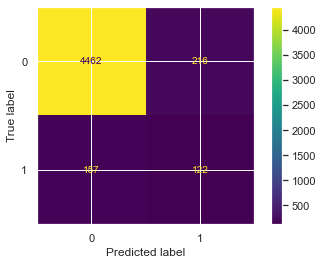

In [12]:
plot_confusion_matrix(SVM_baseline, tfidf_data_test, y_test)

## Baseline with SMOTE
Used to over-sample the minority class (hate speech).

In [14]:
from imblearn.over_sampling import SMOTE
sm= SMOTE()
smote_X_train, smote_y_train = sm.fit_resample(tfidf_data_train, y_train)
# sm = SMOTE(random_state=35)
# smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [15]:
smote_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

In [16]:
%%time
# this cell takes about 4 minutes to run
smote_SVM.fit(smote_X_train, smote_y_train)
smote_SVM_test_preds = smote_SVM.predict(tfidf_data_test)

Wall time: 3min 3s


In [20]:
smote_accuracy = accuracy_score(y_test, smote_SVM_test_preds)
smote_precision = precision_score(y_test, smote_SVM_test_preds)
smote_recall = recall_score(y_test, smote_SVM_test_preds)
smote_f1_score = f1_score(y_test, smote_SVM_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_SVM_test_preds, average='weighted')


In [21]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Oversampled SVM Baseline with Lemmatization')
print('Accuracy: {:.4}'.format(smote_accuracy))
print('Precision: {:.4}'.format(smote_precision))
print('Recall: {:.4}'.format(smote_recall))
print('F1 Score: {:.4}'.format(smote_f1_score))
print('Weighted F1 Score: {:.4}'.format(smote_weighted_f1_score))

Testing Metrics for Oversampled SVM Baseline with Lemmatization
Accuracy: 0.9296
Precision: 0.3438
Recall: 0.276
F1 Score: 0.3062
Weighted F1 Score: 0.926


Looks like SMOTE actually decreased the F1, which also happened with Logistic Regression.

In [22]:
# adding these metrics to evaluation metric dict
metric_dict['Baseline SVM Oversampled with SMOTE'] = {'accuracy': smote_accuracy, 'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score}

## Baseline with Tomek Links
Used to under-sample the majority class (not hate speech).

In [23]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


Only removed 48 values from the majority class.

In [24]:
tomek_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

In [25]:
%%time
# this cell takes 42 seconds to run
tomek_SVM.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_SVM.predict(tfidf_data_test)

Wall time: 31.1 s


In [26]:
tomek_accuracy = accuracy_score(y_test, tomek_logreg_test_preds)
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

In [28]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled SVM Baseline with Lemmatization')
print('Accuracy: {:.4}'.format(tomek_accuracy))
print('Precision: {:.4}'.format(tomek_precision))
print('Recall: {:.4}'.format(tomek_recall))
print('F1 Score: {:.4}'.format(tomek_f1_score))
print('F1 Score: {:.4}'.format(tomek_weighted_f1_score))

Testing Metrics for Undersampled SVM Baseline with Lemmatization
Accuracy: 0.9498
Precision: 0.6562
Recall: 0.2258
F1 Score: 0.336
F1 Score: 0.938


In [29]:
# adding these metrics to evaluation metric dict
metric_dict['Baseline SVM Undersampled with Tomek Links'] = {'accuracy': tomek_accuracy,'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score}

## Metrics for All Baselines

In [30]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,accuracy
Baseline SVM,0.360947,0.437276,0.395462,0.928112,NaN
Baseline SVM Oversampled with SMOTE,0.343750,0.275986,0.306163,0.925951,0.929595
Baseline SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,0.949768


- The baseline SVM with `class_weight=balanced` has the highest unweighted F1
- The undersampled baseline has a lower raw F1, but higher weighted F1.

We can take a look at each model's classification report to get a better idea about what's happening.

In [32]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
# class_weight='balanced' Baseline report
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Undersampled Baseline report
print(classification_report(y_test, tomek_logreg_test_preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      4678
     class 1       0.66      0.23      0.34       279

    accuracy                           0.95      4957
   macro avg       0.81      0.61      0.65      4957
weighted avg       0.94      0.95      0.94      4957



There are some differances. But most noteably, the baseline with `class_weight=balanced` predicts the hate speech (1) class much better than the other model. 

Therefore, let's stick with that one and grid search to tune its hyperparameters.

## Grid Search

The `sklearn` library provides an easy way to tune model parameters through an exhuastive search using `GridSearchCV`. It combines K-Fold Cross Validation with a grid search of hyperparameters.

A full list of an SVC model's hyperparameters can be found in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

With this grid search, I aimed to improve the C and Gamma, and seeing if any other kernels outperform the Linear kernel.

- More information about selecting the right C and gamma can be found in [this](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine) Quora post.
- More information about selecting the right SVM Kernel can be found in [this](https://towardsdatascience.com/svm-and-kernel-svm-fed02bef1200) TowardsDataScience article.

The following hyperparamter dictionary was used and the grid search took about **48 minutes** to run. 

**Grid Searched Parameters:**
- 'C': [1, 10, 100]
- 'gamma': [0.1, 0.01, 0.001]
- 'kernel': ['rbf', 'sigmoid']

For the sake of reproducibility, the tuned model is below. The full code can be found in the `SVM.ipynb` notebook.

In [33]:
# creating the model
baseline_model = svm.SVC(degree=3, class_weight='balanced', random_state=20)

In [34]:
# creating param_dict
param_dict={'C': [1, 10, 100],  
              'gamma': [0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'sigmoid']}

In [35]:
# instantiate Grid Search CV with F1 metric
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring='f1', verbose=3)

In [36]:
%%time
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

# this cell takes 48 minutes to run

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.433 total time=  18.7s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.465 total time=  19.4s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.446 total time=  18.7s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.456 total time=  18.7s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.405 total time=  18.1s
[CV 1/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.439 total time=  19.7s
[CV 2/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.451 total time=  20.0s
[CV 3/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.441 total time=  19.8s
[CV 4/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.450 total time=  21.9s
[CV 5/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.400 total time=  28.7s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.360 total time=  25.1s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=20),
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='f1', verbose=3)

In [37]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)

F1 Score: 0.44115028504856885
Best Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Model object with best parameters: 
SVC(C=1, class_weight='balanced', gamma=0.1, random_state=20)


The grid search found that the best hyperparameters are `{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}`.


In [38]:
# Predict the response for test dataset
grid_base_y_pred_train = grid_baseline.best_estimator_.predict(tfidf_data_train)

# predict the training set
grid_base_y_pred_test = grid_baseline.best_estimator_.predict(tfidf_data_test)

# Model F1, how often is the classifier correct?
print('Tuned SVM Model Predictions')
print("F1 on train set:",metrics.f1_score(y_train, grid_base_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, grid_base_y_pred_test))

Tuned SVM Model Predictions
F1 on train set: 0.7077399380804954
F1 on test set: 0.38513513513513514


In [39]:
# setting variables for evaluation metrics
grid_accuracy = accuracy_score(y_test, grid_base_y_pred_test)
grid_precision = precision_score(y_test, grid_base_y_pred_test)
grid_recall = recall_score(y_test, grid_base_y_pred_test)
grid_f1_score = f1_score(y_test, grid_base_y_pred_test)
grid_weighted_f1_score = f1_score(y_test, grid_base_y_pred_test, average='weighted')

In [40]:
# adding these metrics to evaluation metric dict
metric_dict['Grid Search SVM'] = {'accuracy': grid_accuracy, 'precision': grid_precision, 'recall': grid_recall, 'f1_score': grid_f1_score, 'weighted_f1': grid_weighted_f1_score}

In [41]:
# comparing with other models
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,accuracy
Baseline SVM,0.360947,0.437276,0.395462,0.928112,NaN
Baseline SVM Oversampled with SMOTE,0.343750,0.275986,0.306163,0.925951,0.929595
Baseline SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,0.949768
Grid Search SVM,0.280788,0.612903,0.385135,0.908306,0.889853


Unfortunately, the model with grid searched hyperparameters didn't perform better than the baseline.